In [8]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')

from C60_helper_functions import find_enso_events

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=16)
#cluster.adapt(minimum=2, maximum=16)
client

In [181]:
d=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip',consolidated=True)
for i in d.variables:
    if len(i)<8:
        t='\t\t'
    else:#if len(i)<13:
        t='\t'
    try:
        print(i+t+d[i].units)
    except:
        print(i+t+'no units')

adic		mmol/m^3
alk		mmol/m^3
caco3		mmol/m^3
caco3_sediment	mmolN/m^2
det		mmol/m^3
det_sediment	mmolN/m^2
dic		mmol/m^3
ensemble	no units
export_inorg	mmolC/m^2/s
export_prod	mmolN/m^2/s
fe		mmol/m^3
no3		mmol/m^3
o2		mmol/m^3
paco2		
pco2		
phy		mmol/m^3
pprod_gross	mmolN/m^3/s
pprod_gross_2d	mmolN/m^2/s
scalar_axis	none
st_ocean	meters
stf03		mmol/m^2/s
stf07		mmol/m^2/s
stf10		mmol/m^2/s
surface_adic	mmol/m^3
surface_alk	mmol/m^3
surface_caco3	mmol/m^3
surface_det	mmol/m^3
surface_dic	mmol/m^3
surface_fe	mmol/m^3
surface_no3	mmol/m^3
surface_o2	mmol/m^3
surface_phy	mmol/m^3
surface_zoo	mmol/m^3
time		no units
total_aco2_flux	Pg/yr
total_co2_flux	Pg/yr
xt_ocean	degrees_E
yt_ocean	degrees_N
zoo		mmol/m^3


In [3]:
cafe_co2_all=xr.open_dataset('../processed_data/cafe/eqpac/stf10_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})#/1000)*86400)*-12)#g/m2/day
cafe_co2_nat=xr.open_dataset('../processed_data/cafe/eqpac/stf07_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})#/1000)*86400)*-12)#g/m2/day
#cafe_co2_all=xr.open_dataset('../processed_data/cafe/eqpac/stf03_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})#/1000)*86400)*-12)#g/m2/day
cafe_sst_all=xr.open_dataset('../processed_data/cafe/eqpac/sst_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})
cafe_co2_all_g=((cafe_co2_all/1000)*86400*-12) #g/m2/day
cafe_co2_nat_g=((cafe_co2_nat/1000)*86400*-12) #g/m2/day

cafe_co2_all_g

,Array,Chunk
Bytes,5.43 GiB,12.20 MiB
Shape,"(456, 96, 98, 170)","(1, 96, 98, 170)"
Count,1825 Tasks,456 Chunks
Type,float64,numpy.ndarray


In [25]:
best_ensemble_member=25 # Calculated in 8: Get best ens members.
#Bring all the unit conversions here. 


phy_mean=xr.open_dataset('../processed_data/cafe/eqpac/phy_ensmean_1982_15m_.nc')
#phy_std=xr.open_dataset('../processed_data/eqpac/surface_phy_ensstd_1982.nc')
phy_trend82=xr.open_dataset('../processed_data/cafe/eqpac/phy_meantrends_1982_15m_.nc')
phy_trend20=xr.open_dataset('../processed_data/cafe/eqpac/phy_meantrends_2000_15m_.nc')

#pprod_std=xr.open_dataset('../processed_data/eqpac/pprod_gross_2d_ensstd../_1982.nc')
pprod_mean=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_ensmean_1982.nc')
pprod_trend82=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_meantrends_1982.nc')
pprod_trend20=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_meantrends_2000.nc')


#LOAD CAFE SST AND CO2 FLUX
cafe_sst_std=xr.open_dataset('../processed_data/cafe/global/sst_ensstd_1982.nc')
cafe_sst_mean=xr.open_dataset('../processed_data/cafe/global/sst_ensmean_1982.nc')
cafe_sst_82tr=xr.open_dataset('../processed_data/cafe/global/sst_meantrends_1982.nc')
cafe_sst_20tr=xr.open_dataset('../processed_data/cafe/global/sst_meantrends_2000.nc')


cafe_co2_std=xr.open_dataset('../processed_data/cafe/global/stf10_ensstd_1982.nc')
cafe_co2_mean=xr.open_dataset('../processed_data/cafe/global/stf10_ensmean_1982.nc')
cafe_co2_82tr=xr.open_dataset('../processed_data/cafe/global/stf10_meantrends_1982.nc')
cafe_co2_20tr=xr.open_dataset('../processed_data/cafe/global/stf10_meantrends_2000.nc')


#Load CO2 and SST OBS PRODUCTS
land_co2=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365 #g/m2/day
land_co2_82tr=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid_trend_1982.nc')
land_co2_20tr=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid_trend_2000.nc')

rodenbeck_co2=xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid.nc')
rodenbeck_co2_82tr=xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid_trend_1982.nc')
rodenbeck_co2_20tr=xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid_trend_2000.nc')
# #/(10**15/365) #Convert from PgC/Yr to gC/day


rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc')
rey_sst_82tr=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.trend.1982.nc')
rey_sst_20tr=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.trend.2000.nc')

In [6]:

from C60_helper_functions import find_enso_events

In [31]:
find_enso_events(threshold=0.5,data_path='../external_data/indexes/',out_path='../processed_data/indexes/')

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/C60_helper_functions.py:154: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  emi.time=emi.Date.astype('datetime64[M]')


saved to: ../processed_data/indexes/el_nino_events.csv
saved to: ../processed_data/indexes/la_nino_events.csv
saved to: ../processed_data/indexes/cp_events.csv
saved to: ../processed_data/indexes/ep_events.csv


In [7]:
pwd

'/home/581/np1383'

In [14]:
#Check the calculation of these indexes look a bit wrong.
el_new=pd.read_csv('../processed_data/indexes/el_nino_events.csv')
la_new=pd.read_csv('../processed_data/indexes/la_nina_events.csv')
ep_new=pd.read_csv('../processed_data/indexes/ep_events.csv')
cp_new=pd.read_csv('../processed_data/indexes/cp_events.csv')

In [26]:
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')

In [27]:
#Process EP, CP and Nino events.


In [34]:
info

<xarray.DataArray 'time' (time: 456)>
array(['1982-01-01T00:00:00.000000000', '1982-02-01T00:00:00.000000000',
       '1982-03-01T00:00:00.000000000', ..., '2019-10-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01

In [53]:
x=[]

In [55]:
x.append(list(info.sel(time=slice(i[1].start,i[1].end)).time.values))

In [58]:
info.sel(time=slice(i[1].start,i[1].end)).time.values

array(['1988-06-01T00:00:00.000000000', '1988-07-01T00:00:00.000000000',
       '1988-08-01T00:00:00.000000000', '1988-09-01T00:00:00.000000000',
       '1988-10-01T00:00:00.000000000', '1988-11-01T00:00:00.000000000',
       '1988-12-01T00:00:00.000000000', '1989-01-01T00:00:00.000000000',
       '1989-02-01T00:00:00.000000000', '1989-03-01T00:00:00.000000000',
       '1989-04-01T00:00:00.000000000', '1989-05-01T00:00:00.000000000',
       '1989-06-01T00:00:00.000000000', '1989-07-01T00:00:00.000000000',
       '1989-08-01T00:00:00.000000000', '1989-09-01T00:00:00.000000000',
       '1989-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [177]:
nina=pd.DataFrame()
#nino=pd.DataFrame()
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=cafe_sst_mean.time


def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values

In [170]:
neutral[0]

Timestamp('1982-01-01 00:00:00')

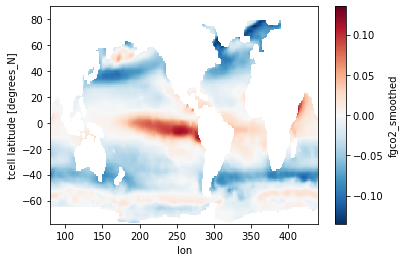

In [179]:
land_co2.sel(time=neutraal_events).mean(dim='time').fgco2_smoothed.plot()

In [189]:
best_ens=25

bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20),ensemble=best_ens)
eqpac['time']=np.array(eqpac.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
#eqpac.time
eqpac

/local/v45/np1383/tmp/ipykernel_3293627/3555370358.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  eqpac['time']=np.array(eqpac.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


,Array,Chunk
Bytes,2.23 GiB,195.23 kiB
Shape,"(720, 50, 98, 170)","(1, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.23 GiB,195.23 kiB
Shape,"(720, 50, 98, 170)","(1, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


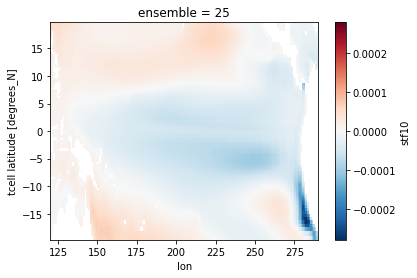

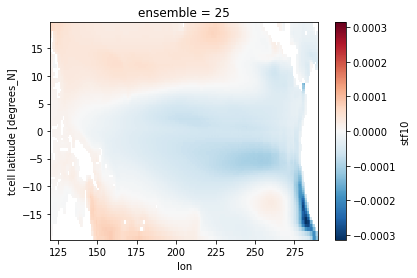

In [193]:
eqpac.stf10.sel(time=cp_events,method='nearest').mean(dim='time').plot()

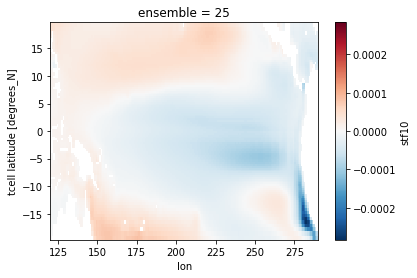

In [194]:
eqpac.stf10.sel(time=ep_events,method='nearest').mean(dim='time').plot()

In [23]:
#Conversion to g/m2/day     /1000)*86400*-12

In [218]:
cp_events

array(['1982-03-01T00:00:00.000000000', '1982-04-01T00:00:00.000000000',
       '1982-05-01T00:00:00.000000000', '1982-06-01T00:00:00.000000000',
       '1982-07-01T00:00:00.000000000', '1990-08-01T00:00:00.000000000',
       '1990-09-01T00:00:00.000000000', '1990-10-01T00:00:00.000000000',
       '1990-11-01T00:00:00.000000000', '1990-12-01T00:00:00.000000000',
       '1991-01-01T00:00:00.000000000', '1991-02-01T00:00:00.000000000',
       '1991-03-01T00:00:00.000000000', '1991-04-01T00:00:00.000000000',
       '1991-05-01T00:00:00.000000000', '1991-08-01T00:00:00.000000000',
       '1991-09-01T00:00:00.000000000', '1991-10-01T00:00:00.000000000',
       '1991-11-01T00:00:00.000000000', '1991-12-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1992-02-01T00:00:00.000000000',
       '1994-03-01T00:00:00.000000000', '1994-04-01T00:00:00.000000000',
       '1994-05-01T00:00:00.000000000', '1994-06-01T00:00:00.000000000',
       '1994-07-01T00:00:00.000000000', '1994-08-01

In [220]:
eval('cp_events')

array(['1982-03-01T00:00:00.000000000', '1982-04-01T00:00:00.000000000',
       '1982-05-01T00:00:00.000000000', '1982-06-01T00:00:00.000000000',
       '1982-07-01T00:00:00.000000000', '1990-08-01T00:00:00.000000000',
       '1990-09-01T00:00:00.000000000', '1990-10-01T00:00:00.000000000',
       '1990-11-01T00:00:00.000000000', '1990-12-01T00:00:00.000000000',
       '1991-01-01T00:00:00.000000000', '1991-02-01T00:00:00.000000000',
       '1991-03-01T00:00:00.000000000', '1991-04-01T00:00:00.000000000',
       '1991-05-01T00:00:00.000000000', '1991-08-01T00:00:00.000000000',
       '1991-09-01T00:00:00.000000000', '1991-10-01T00:00:00.000000000',
       '1991-11-01T00:00:00.000000000', '1991-12-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1992-02-01T00:00:00.000000000',
       '1994-03-01T00:00:00.000000000', '1994-04-01T00:00:00.000000000',
       '1994-05-01T00:00:00.000000000', '1994-06-01T00:00:00.000000000',
       '1994-07-01T00:00:00.000000000', '1994-08-01

In [222]:
land_co2.fgco2_smoothed

<xarray.Dataset>
Dimensions:         (time: 456, lon: 360, lat: 300)
Coordinates:
  * time            (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lon             (lon) float64 80.5 81.5 82.5 83.5 ... 437.5 438.5 439.5
  * lat             (lat) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
Data variables:
    fgco2_smoothed  (time, lat, lon) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0

In [23]:
eqpac.stf10.sel(time=neutral_events,method='nearest').mean(dim='time').plot()

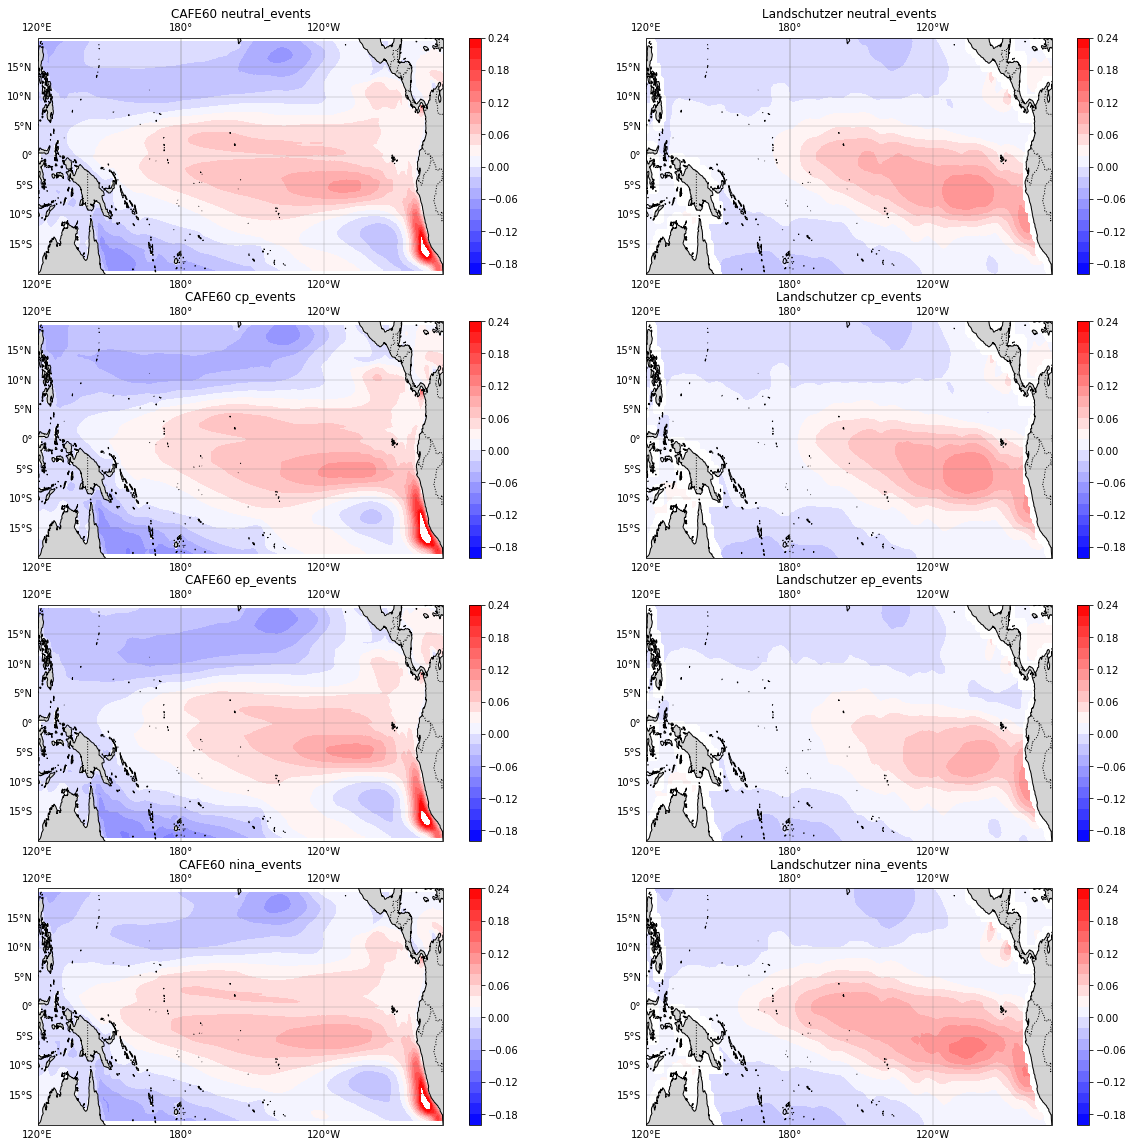

In [251]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,20))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['neutral_events','cp_events','ep_events','nina_events']):
    for i,product in enumerate(['CAFE60','Landschutzer']):
    
        ax = plt.subplot(4,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=(eqpac.stf10/1000)*86400*-12
        elif i==1:
            dat=land_co2.fgco2_smoothed
        data=dat.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-0.2,0.25,0.02))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' '+event_name)
        plot_counter+=1
plt.show()

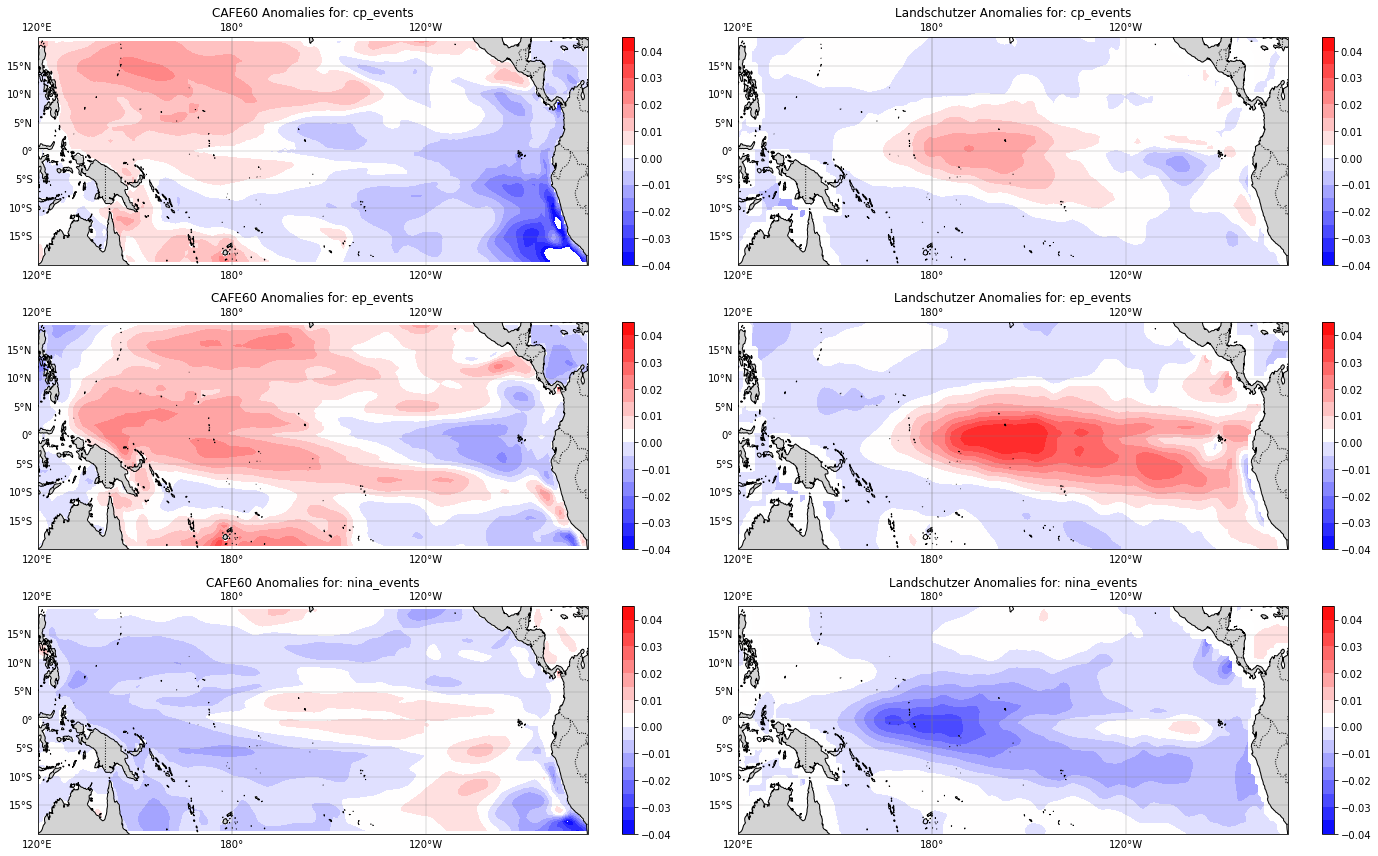

In [252]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,12))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['cp_events','ep_events','nina_events']):
    for i,product in enumerate(['CAFE60','Landschutzer']):
    
        ax = plt.subplot(3,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=(eqpac.stf10/1000)*86400*-12
        elif i==1:
            dat=land_co2.fgco2_smoothed
        data=dat.sel(time=neutral_events,method='nearest').mean(dim='time')-dat.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-0.04,0.05,0.005))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' Anomalies for: '+event_name)
        plot_counter+=1
plt.tight_layout()
plt.show()

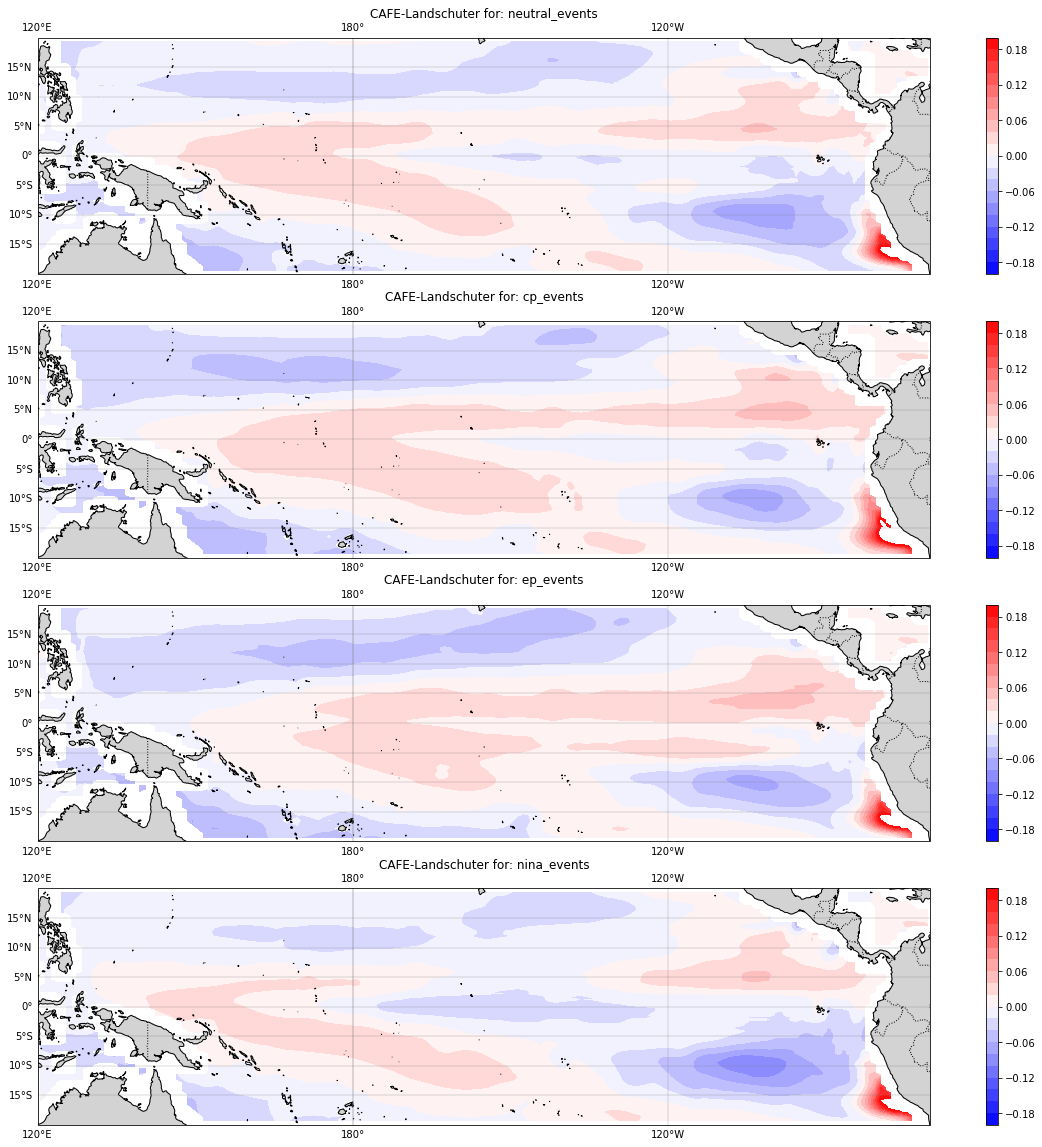

In [254]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,20))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['neutral_events','cp_events','ep_events','nina_events']):

        ax = plt.subplot(4,1,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
     
        cafe=(eqpac.stf10/1000)*86400*-12
        land=land_co2.fgco2_smoothed
        
        data=cafe.sel(time=times,method='nearest').mean(dim='time')-land.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-0.20,0.22,0.02))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title('CAFE-Landschuter for: '+event_name)
        plot_counter+=1
plt.show()

In [235]:
best_ens=25

phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})
phys['lon']=phys['lon']+360
eqpac_phys=phys.sel(lon=slice(120,290),lat=slice(-20,20),ensemble=best_ens)
eqpac_phys['time']=np.array(eqpac_phys.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
#eqpac.time
eqpac_phys.sst

/local/v45/np1383/tmp/ipykernel_3293627/752416095.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  eqpac_phys['time']=np.array(eqpac_phys.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


,Array,Chunk
Bytes,2.23 GiB,195.23 kiB
Shape,"(720, 50, 98, 170)","(1, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.23 GiB,195.23 kiB
Shape,"(720, 50, 98, 170)","(1, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [234]:
rey_sst.sst

In [234]:
# DO SST NOW

<xarray.Dataset>
Dimensions:  (time: 456, lat: 300, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lon      (lon) float64 80.5 81.5 82.5 83.5 84.5 ... 436.5 437.5 438.5 439.5
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
Data variables:
    sst      (time, lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear

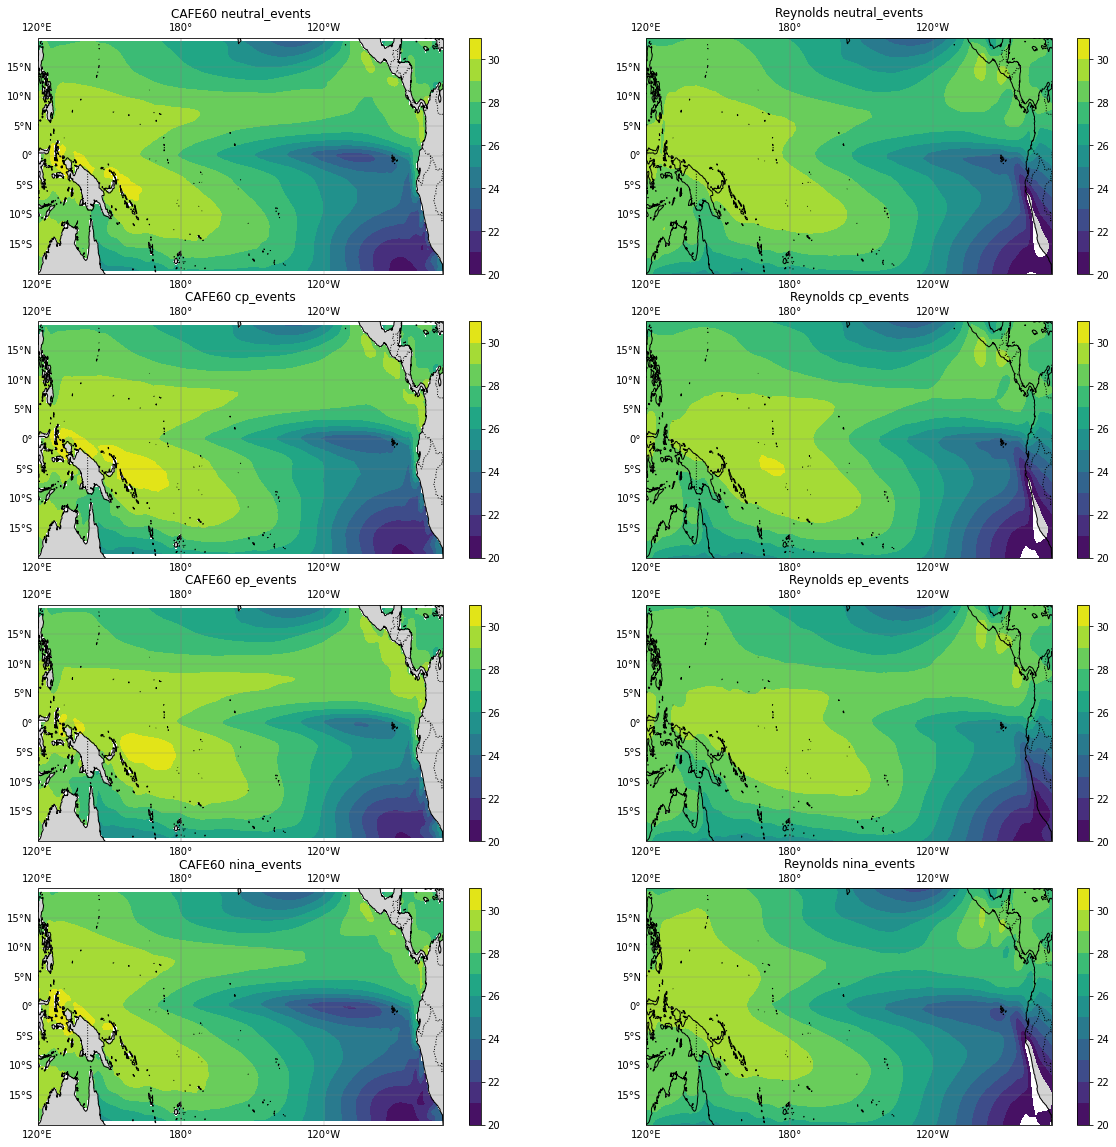

In [241]:
# SHOW DIFFERENCES BETWEEN CAFE AND Reynolds SST AT ENSO PHASE.
fig = plt.figure(figsize=(20,20))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['neutral_events','cp_events','ep_events','nina_events']):
    for i,product in enumerate(['CAFE60','Reynolds']):
    
        ax = plt.subplot(4,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=eqpac_phys.sst
        elif i==1:
            dat=rey_sst.sst
        data=dat.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='viridis',levels=np.arange(20,32,1))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' '+event_name)
        plot_counter+=1
plt.show()

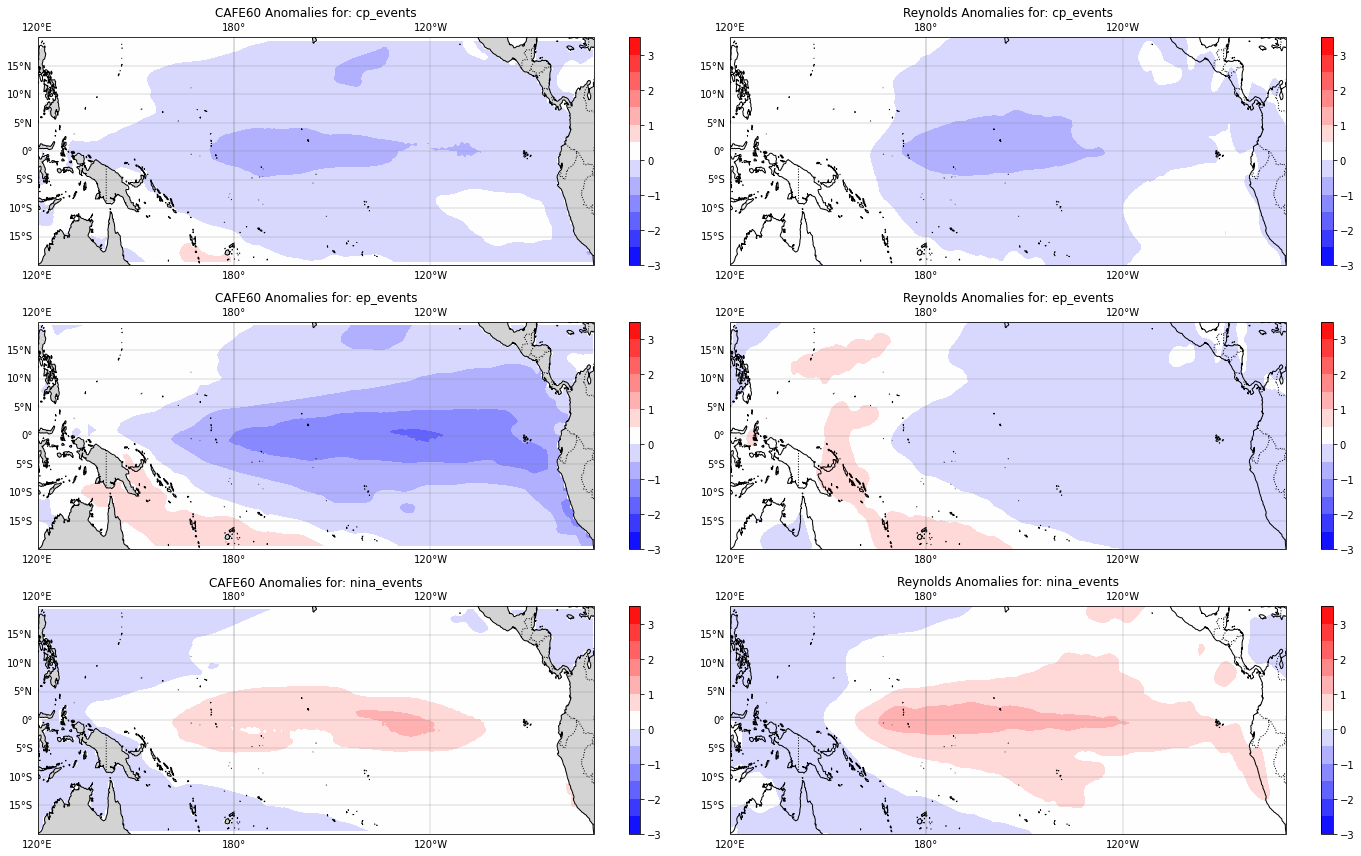

In [249]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,12))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['cp_events','ep_events','nina_events']):
    for i,product in enumerate(['CAFE60','Reynolds']):
    
        ax = plt.subplot(3,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=eqpac_phys.sst
        elif i==1:
            dat=rey_sst.sst
        data=dat.sel(time=neutral_events,method='nearest').mean(dim='time')-dat.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-3,4,0.5))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' Anomalies for: '+event_name)
        plot_counter+=1
plt.tight_layout()
plt.show()

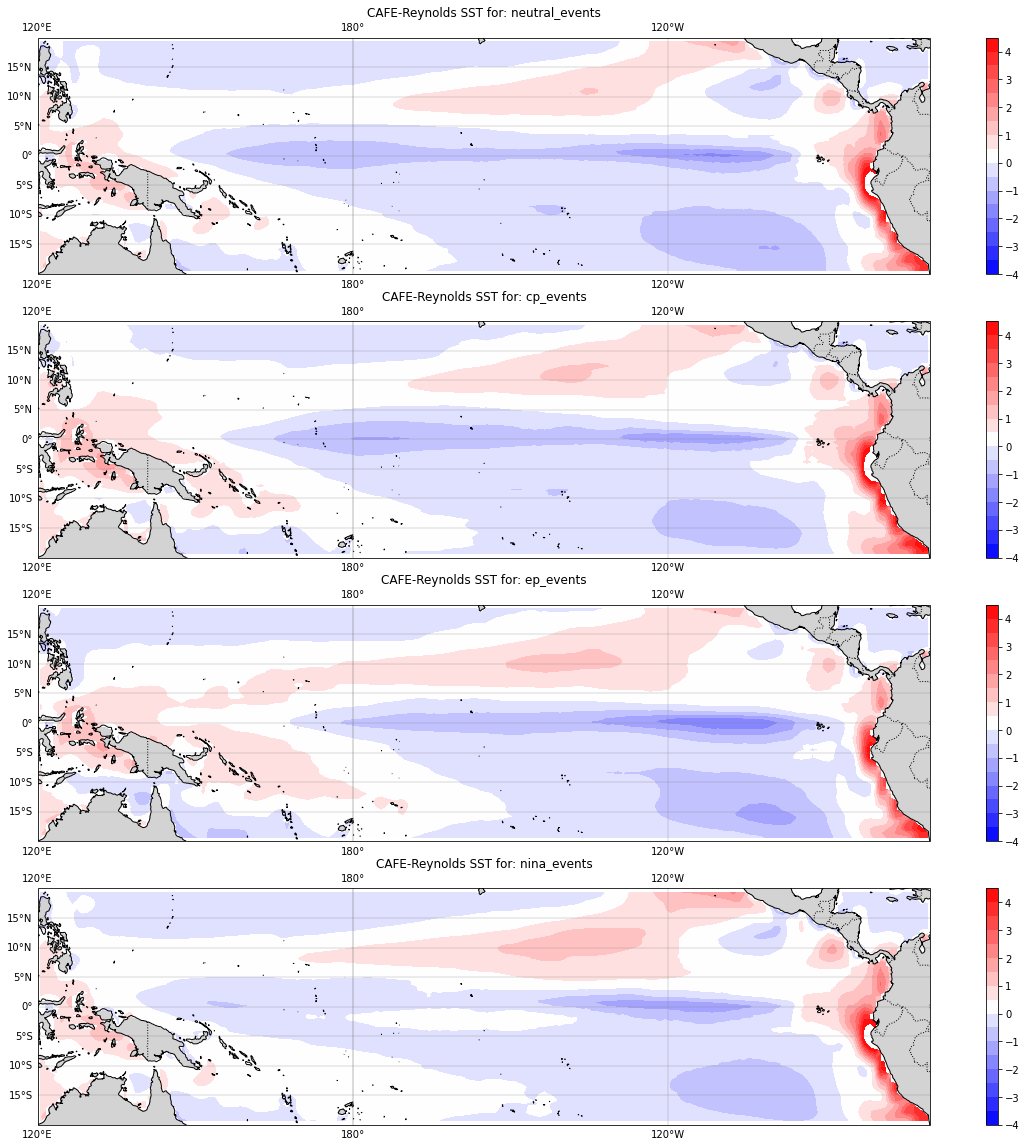

In [250]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,20))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['neutral_events','cp_events','ep_events','nina_events']):

        ax = plt.subplot(4,1,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
     
        cafe=eqpac_phys.sst
        reynolds=rey_sst.sst

        data=cafe.sel(time=times,method='nearest').mean(dim='time')-reynolds.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-4,5,0.5))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title('CAFE-Reynolds SST for: '+event_name)
        plot_counter+=1
plt.show()